#Klassifikation von Song-Texten
Die Aufgabe, oder auch das Ziel besteht darin, dass man anhand von Song-Texten vorhersagt von welchem Genre ein Lied ist. Bei der Umsetzung soll man unterschiedliche Methoden verwenden und diese untereinander auch vergleichen, dabei sollen die unterschiedlichen Methoden aus dem Machine Learning Beziehungsweise aus dem Deep Learning Bereichen kommen. Die Umsetzung des Projektes ist in folgenden Schritten entwickelt worden:

1. Im ersten Schritt werden die Daten so weit vorbereitet Beziehungsweise bereinigt, sodass man mit ihnen die zuvor genannten Ziele auch erreichen kann. Die verwendeten Roh-Daten stammen von “https://www.kaggle.com/neisse/scrapped-lyrics-from-6-genres”.

2. Es wurde eine Baseline erstellt, um die Genauigkeit des neurnales Netzwerkes zu vergleichen. Dazu wurde Naive Bayes mit additiver Glättung verwenden.

3. Im dritten Schritte wurde ein Feed-Forward-Netzwerk erstellt und verbessert.

4. Zum Schluss wurde noch ein Recurrent-Neural-Network trainiert.

Es werden die Genres Rock, Pop, Hip Hop, Samba, Sertanejo und Funk Carioca benutzt. 

In [3]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from keras.layers import Dropout

# load dataset 
pathLyrics = 'lyrics-data.csv'
pathArtists = 'artists-data.csv'


dataframe = pd.read_csv(pathLyrics)
dataframeArtists = pd.read_csv(pathArtists)

#Data preparation

Wie schon oben in der Kurzbeschreibung erwähnt, findet im ersten Schritt die Verarbeitung von Roh-Daten, die so weit vorbereitet bzw. bereinigt werden müssen, sodass man diese für die verschiedene Modelle verwenden kann. Da es sich bei den Kaggle-Daten um große Datenmengen handelt, wurden die irrelevanten Datensätze entfernt. Einer der Bereinigungsschritte ist es, dass man sich nur auf Englische Song-Text fokussiert, sodass die anderen Sprachen dabei entfernt werden. Die zwei importierten CSV-Dateien zu Genre und Texten werden zusammengeführt, sodass aus Tabelle Artists und der Tabelle Songs eine gemeinsame Tabelle erstellt wird. Diese Tabelle wird auf die nötigsten Informationen verkleinert um die zu verarbeitende Daten klein zu halten. Song-Texte die irrelevante Sonderzeichen, Noten oder auch keine Texte beinhalten werden auch entfernt. Des Weiteren ist einer der Schritte, dass alle Song-Text in kleingeschriebene Wörter angepasst worden, für eine bessere Verabeitung der Texte. 

Ein Problem, welches bei der Datenvorbereitung aufgetreten ist, dass zwei identische Songtexte unterschiedliche Genres besitzen. Die Datensätze befinden sich in zwei getrennten CSV-Dateien. In der Datei "artists-data.csv" befinden sich neben weiteren Informationen der Artist und das Genre. Es ist ebenfalls in der Spalte "Genres" mehrere Genres angegeben, da ein Song auch meherere Gernes wie zum Beispiel Pop und Hip Hop haben kann. In der CSV-Datei "lyrics-data.csv" befinden unteranderem der Songtext und das Idiom. Der join der beiden CSV-Dateien wird über die Spalte "ALink" bei der CSV-Datei "lyrics-data.csv" und über die Spalte "Link" gemacht. 


Die Zuordnung zwischen Artits und Song wird über die Spalte "ALink" bei der CSV-Datei "lyrics-data.csv" und über die Spalte "Link" bei der CVS-Datei "artists-data.csv" gemacht. Es kann nun vorkommen, dass ein Künster, z.B. 10000 Maniacs, jeweils mit unterschiedlichen "Genre" aber gleichem "Link" im Datensatz vorkommt. Dies führt dazu, dass bei einem Join ein Song zweimal mit anderem Genre vorkommt. Zum Beheben dieses Problem wird nach dem Zusammenführen der CSV-Dateien über alle Zeilen iteriert und das Genre sowie der erste Eintrag in der Spalte "Genres". Sollte diese nicht übereinstimmen, werden die entsprechenden Zeilen gelöscht.        



In [ ]:
from sklearn.utils import shuffle

#Filtert alle Songtext, die nicht Englisch sind
dataframe = dataframe[dataframe['Idiom'] == 'ENGLISH']
#Lowercase alle Songtexte
dataframe['Lyric'] = dataframe['Lyric'].apply(lambda lyric: lyric.lower())

#Herausfiltern der Instrumentals 
patternDel = ["---", "instrumental","==="]
for patt in patternDel:
    filter = dataframe['Lyric'].str.contains(patt)
    dataframe = dataframe[~filter]

#Join der zwei CSV Dateien   
dataframe.rename(columns={'ALink':'Link','SName':'SName', 'SLink':'SLink','Lyric':'Lyric','Idiom':'Idiom'},inplace=True)
mergeData=pd.merge(dataframe, dataframeArtists, on='Link')

#Löschen aller Zeilen bei denen "Genre" und erstes Genre in "Genres" nicht übereinstimmen. Es wird durch die 
#Zeilen iteriert. Dabei wird der String in "Genres" gesplittet und in eine Liste geschrieben. Anschließend wird 
#verglichen. In listOfIndex stehen alle zu löschenden Indexe.
listOfIndex=[]
for ind in mergeData.index:
    if type(mergeData['Genres'][ind]) is str: 
        s_gerne = mergeData['Genre'][ind]
        #Splitten von "Genres"
        s_gernres = mergeData['Genres'][ind].split(";")
        if s_gerne !=  s_gernres[0]:
            listOfIndex.append(ind)
    else:
        listOfIndex.append(ind)
              
mergeData.drop(listOfIndex,inplace=True )

#Die Zeilen sind sortiert, deshalb muss noch gemischt werden.
rawData = shuffle(mergeData)


Durch die Entfernung aller nicht englischen Songtexten, dem Löschen alle Instrumentals und ähnliches sowie die Entfernung der mehrfach vorhandenen Songtexten stehen XXXXXXXXXX! Datensätze zum Trainieren zur Verfügung.

#Baseline

Als Baseline zum Vergleich des neuronalen Netzwerkes wird Naive Bayes mit additiver Glättung verwendet. Die Datensätze wurden zu 80% Trainings- und Validierungsdaten sowie 20% für die Evaluierung aufgeteilt.   

In [3]:
vectorizer = CountVectorizer()
X_cnt = vectorizer.fit_transform(rawData['Lyric'])

label_encoder = LabelEncoder()
y_clean = label_encoder.fit_transform(rawData['Genre'])

X_train, X_test, y_train, y_test = train_test_split(X_cnt, y_clean, test_size=0.2, random_state=0)

## Naive Bayes mit additiver Glättung trainieren
nb = MultinomialNB(alpha=1.0)
nb.fit(X_train, y_train)

## Vorhersagen berechnen
y_predicted = nb.predict(X_test)


## Konfusionsmatrix ausgeben
print("Kofusionsmatrix:\n", confusion_matrix(y_true=y_test, y_pred=y_predicted))

## Gütemaße ausgeben
print("Korrektklassifizierungsrate:\n", accuracy_score(y_true=y_test, y_pred=y_predicted))
print("Präzision (mikro):\n", precision_score(y_true=y_test, y_pred=y_predicted, average='micro'))
print("Ausbeute (mikro):\n", recall_score(y_true=y_test, y_pred=y_predicted, average='micro'))
print("F1 (mikro):\n", f1_score(y_true=y_test, y_pred=y_predicted, average='micro'))

Kofusionsmatrix:
 [[   0    0    2    0    0    0]
 [   0 1592  570  132    0    0]
 [   0  265 2422 1236    0    5]
 [   1  223 1357 4509    0    4]
 [   0    1    4    4    0    0]
 [   0    0    5    8    0    0]]
Korrektklassifizierungsrate:
 0.6906807131280389
Präzision (mikro):
 0.6906807131280389
Ausbeute (mikro):
 0.6906807131280389
F1 (mikro):
 0.6906807131280389


In [ ]:
In diesem liefert der Klassifikator eine Genauigkeit von ca. 69%. 

#Feed Forward Network (FFN)
Im Folgenden wird ein neuronales Netzwerk für die Vorhersage der Genres genutzt. Zuerst werden zwei Funktionen definiert die später mehrfach benötigt werden. Die Funktion "vectorize_sequences" ist dafür zuständig, den Songtext als binären Vektor darzustellen, der One-Hot-Encoded ist. Dies ist notwenig, da das FFN immer die gleiche Input-Länge benötigt. Es werden 100000 Dimensionen verwenden. Zusätzlich werden nochmal alle Sonderzeichen gefiltert. 

Die zweite Funktion "vectorize_labels" sorgt dafür, dass die Genres bzw. die Labels ebenfalls One-Hot-Encoded werden. 

In [6]:
def vectorize_sequences (dataframe, dimensions=10000):
    vect = CountVectorizer()
    X = vect.fit_transform(dataframe)
    tokenizer = Tokenizer(num_words=dimensions, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(dataframe)
    sequences = tokenizer.texts_to_sequences(dataframe)
    one_hot_results = tokenizer.texts_to_matrix(dataframe, mode='binary')
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    return one_hot_results
    
def vectorize_labels(labels):
    le = preprocessing.LabelEncoder()
    encodedlabels = le.fit(labels)
    encodedlabels_transformed= le.transform(labels) 
    return to_categorical(encodedlabels_transformed)

Die Liedtext werden in einen Vektor umgewandelt und die Genres werden umgewandelt. Die Aufteilung in Trainings- und Evaluierungsdaten ist 80/20. 

In [6]:
X_cnt = vectorize_sequences(rawData['Lyric'])
y_clean = vectorize_labels(rawData['Genre'])

X_train, X_test, y_train, y_test = train_test_split(X_cnt, y_clean, test_size=0.2, random_state=0)

Found 101195 unique tokens.


Das Modell besteht aus insgesamt drei verschiedenen Schichten. Die Ausgabeschicht besteht insgesamt aus sechs Neuronen, für jede Kategorie eine. Da es sich um ein multi-class Klassifizierungsproblem handelt ist die Loss-Funktion "categorical_crossentropy". Die Aktivierungsfunktion ist "softmax". Die Ausgabewerte der Ausgabeschicht sind die Wahrscheinlichkeiten mit welchem die Genres klassifiziert werden. 

In [7]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 102       
Total params: 160,390
Trainable params: 160,390
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(X_train, y_train, epochs=50,batch_size=100, validation_split=0.2)

Train on 39487 samples, validate on 9872 samples
Epoch 1/50
39487/39487 [==============================] - 9s 231us/step - loss: 1.1324 - accuracy: 0.5407 - val_loss: 0.7867 - val_accuracy: 0.6821
Epoch 2/50
39487/39487 [==============================] - 6s 142us/step - loss: 0.7307 - accuracy: 0.6917 - val_loss: 0.6986 - val_accuracy: 0.7000
Epoch 3/50
39487/39487 [==============================] - 6s 145us/step - loss: 0.6840 - accuracy: 0.7079 - val_loss: 0.6729 - val_accuracy: 0.7156
Epoch 4/50
39487/39487 [==============================] - 7s 187us/step - loss: 0.6585 - accuracy: 0.7206 - val_loss: 0.6518 - val_accuracy: 0.7238
Epoch 5/50
39487/39487 [==============================] - 8s 198us/step - loss: 0.6389 - accuracy: 0.7294 - val_loss: 0.6390 - val_accuracy: 0.7306
Epoch 6/50
39487/39487 [==============================] - 8s 200us/step - loss: 0.6226 - accuracy: 0.7357 - val_loss: 0.6282 - val_accuracy: 0.7353
Epoch 7/50
39487/39487 [==============================] - 8s 21

In [ ]:
Die 

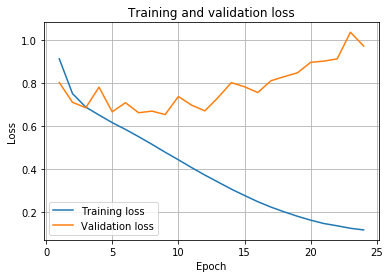

In [31]:
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [30]:

# compute loss and accuracy on test data
score = model.evaluate( X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

6170/6170 [==============================] - 59s 10ms/step
Test score: 0.774905686768759
Test accuracy: 0.6536466479301453


In [32]:
history_dict = history.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

KeyError: 'accuracy'

# Enhanced FFN

In [336]:
tfidf_vectorizer=TfidfVectorizer(stop_words="english",max_features=10000, ngram_range=(1, 3),use_idf=True )
#tfidf_vectorizer=TfidfVectorizer(max_features=10000,use_idf=False )

xtrain_tfidf = tfidf_vectorizer.fit(rawData['Lyric'])

X_cnt = xtrain_tfidf.transform(rawData['Lyric'])
y_clean = vectorize_labels(rawData['Genre'])



X_train, X_test, y_train, y_test = train_test_split(X_cnt, y_clean, test_size=0.2, random_state=0) #, shuffle=True)

In [339]:
model_tfidf = models.Sequential()
model_tfidf.add(layers.Dense(512, activation='relu', input_shape=(10000,)))
model_tfidf.add(layers.Dense(256, activation='relu'))
model_tfidf.add(layers.Dense(6, activation='softmax'))
model_tfidf.compile(optimizer='SGD', loss='categorical_crossentropy', metrics=['accuracy'])
model_tfidf.summary()


Model: "sequential_72"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_212 (Dense)            (None, 512)               5120512   
_________________________________________________________________
dense_213 (Dense)            (None, 256)               131328    
_________________________________________________________________
dense_214 (Dense)            (None, 6)                 1542      
Total params: 5,253,382
Trainable params: 5,253,382
Non-trainable params: 0
_________________________________________________________________


In [343]:
history_tfidf = model_tfidf.fit(X_train, y_train, epochs=50, batch_size=100, validation_split=0.2)

Train on 39487 samples, validate on 9872 samples
Epoch 1/50
39487/39487 [==============================] - 7s 182us/step - loss: 0.7158 - accuracy: 0.6799 - val_loss: 0.7095 - val_accuracy: 0.6880
Epoch 2/50
39487/39487 [==============================] - 8s 191us/step - loss: 0.7085 - accuracy: 0.6837 - val_loss: 0.7042 - val_accuracy: 0.6834
Epoch 3/50
39487/39487 [==============================] - 9s 222us/step - loss: 0.7011 - accuracy: 0.6894 - val_loss: 0.7057 - val_accuracy: 0.6773
Epoch 4/50
39487/39487 [==============================] - 9s 221us/step - loss: 0.6945 - accuracy: 0.6931 - val_loss: 0.6939 - val_accuracy: 0.6922
Epoch 5/50
39487/39487 [==============================] - 9s 229us/step - loss: 0.6874 - accuracy: 0.6965 - val_loss: 0.6892 - val_accuracy: 0.6979
Epoch 6/50
39487/39487 [==============================] - 9s 233us/step - loss: 0.6809 - accuracy: 0.6997 - val_loss: 0.6890 - val_accuracy: 0.7031
Epoch 7/50
39487/39487 [==============================] - 9s 23

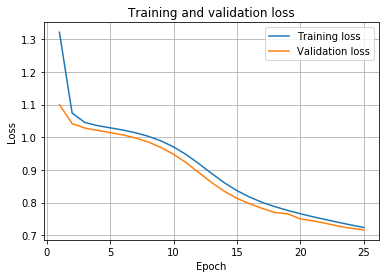

In [341]:
history_dict = history_tfidf.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [342]:
#xtest_tfidf = tfidf_vectorizer.fit(rawData['Lyric'])

#X_test = xtest_tfidf.transform(test['Lyric'])


#Y_test = vectorize_labels(test['Genre'])

# compute loss and accuracy on test data
score = model_tfidf.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

12340/12340 [==============================] - 2s 178us/step
Test score: 0.7363430395118614
Test accuracy: 0.6688817143440247


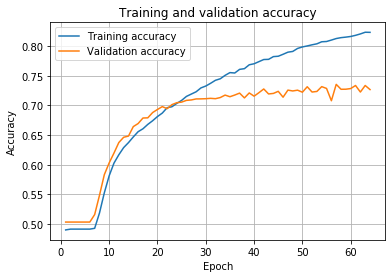

In [287]:
history_dict = history_tfidf.history
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

#Long short-term memory neural network

In [11]:
import numpy as np
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Flatten
from keras.preprocessing import sequence
from keras.initializers import Constant


# number of most frequent words to consider
num_words = 10000

# maximum length of reviews (only the first so many words are considered)
max_len = 500

# embedding dimensionality
emb_dim = 300

rawData = pd.read_csv('cleanedDataset.csv')


In [12]:
#Data Prep

In [20]:
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(rawData['Lyric'])
sequences = tokenizer.texts_to_sequences(rawData['Lyric'])
X_clean = sequence.pad_sequences(sequences,maxlen=max_len)

Y_clean = vectorize_labels(rawData['Genre'])


X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.1, random_state=0, shuffle=True)

In [21]:
embeddings_index = {}
f = open('glove.6B.300d.txt',encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


word_index= tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, emb_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
num_words = min(num_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, emb_dim))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
        
        

Found 400000 word vectors.


In [ ]:
model = Sequential()
model.add((Embedding(num_words,emb_dim, 
                    embeddings_initializer=Constant(embedding_matrix),input_length=max_len,
                    trainable=False)))
model.add(LSTM(128, recurrent_dropout=0.8, dropout=0.8))
#model.add(LSTM(128))
model.add(Dense(6, activation='softmax'))
model.summary() 

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train,y_train, epochs=24, batch_size=200, validation_split=0.2)



Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 500, 300)          3000000   
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 774       
Total params: 3,220,422
Trainable params: 220,422
Non-trainable params: 3,000,000
_________________________________________________________________
Train on 44423 samples, validate on 11106 samples
Epoch 1/24
44423/44423 [==============================] - 567s 13ms/step - loss: 1.0435 - acc: 0.4892 - val_loss: 0.9805 - val_acc: 0.5176
Epoch 2/24
44423/44423 [==============================] - 602s 14ms/step - loss: 0.9816 - acc: 0.5181 - val_loss: 0.9364 - val_acc: 0.5516
Epoch 3/24
44423/44423 [===============

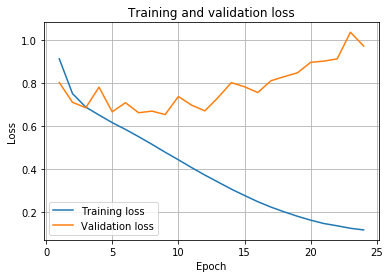

In [27]:
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

In [28]:
# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

6170/6170 [==============================] - 44s 7ms/step
Test score: 0.9294884932099131
Test accuracy: 0.7635332345962524


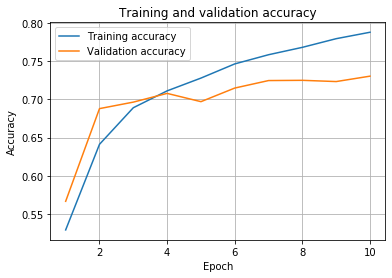

In [379]:
history_dict = history.history
train_acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

,Link,SName,SLink,Lyric,Idiom,Artist,Songs,Popularity,Genre,Genres
13194,/david-bowie/,Law [Earthing On Fire],/david-bowie/law-earthing-on-fire.html,"i don't want knowledge, i want certainty. i do...",ENGLISH,David Bowie,458,8.1,Rock,Rock; Pop/Rock; Folk; Psicodelia; Soul Music; ...
53220,/ted-nugent/,Just What The Doctor Ordered,/ted-nugent/just-what-the-doctor-ordered.html,i got my guitar when i was 10 years old. found...,ENGLISH,Ted Nugent,27,0.1,Rock,Rock; Instrumental
68134,/beyonce/,***Flawless (Feat. Nicki Minaj),/beyonce/flawless-feat-nicki-minaj.html,"dum-da-de-da. do, do, do, do, do, do. (coming ...",ENGLISH,Beyoncé,249,40.8,Pop,Pop; R&B; Black Music; Romântico; Dance; Hip H...
62871,/van-morrison/,Dweller On The Threshold,/van-morrison/dweller-on-the-threshold.html,i'm a dweller on the threshold. and i'm waitin...,ENGLISH,Van Morrison,496,0.8,Rock,Rock; Soul Music; Folk; R&B; Blues; Jazz
119317,/sugababes/,Red Dress (extended Version),/sugababes/red-dress-extended-version.html,cause i'm cooler than the red dress. cause i'm...,ENGLISH,Sugababes,134,0.2,Pop,Pop; R&B; Dance; Trilha Sonora; Tecnopop
...,...,...,...,...,...,...,...,...,...,...
79265,/jay-z/,Umbrella (Cinderella remix),/jay-z/umbrella-cinderella-remix.html,"[jay-z]. ahuh ahuh (yea rihanna, chris brown)....",ENGLISH,Jay-Z,312,4.0,Hip Hop,Hip Hop; Rap; Black Music; World Music; House;...
102337,/david-archuleta/,Invincible,/david-archuleta/invincible.html,i started a war. i sent out a battle cry. and ...,ENGLISH,David Archuleta,126,0.6,Pop,Pop; Romântico; Pop/Rock; Gospel/Religioso
74526,/eminem/,8 Mile Freestyle - Vs. Lotto,/eminem/8-mile-lotto-vs-rabbit.html,"[lotto]. yo, i spit a racial slur. honky, sue ...",ENGLISH,Eminem,446,79.9,Hip Hop,Hip Hop; Rap; Black Music; Funk; Electronica; ...
38107,/neil-young/,Your Love,/neil-young/your-love.html,your love is good to me. i should be standing ...,ENGLISH,Neil Young,490,3.1,Rock,Rock; Folk; Grunge; Country; Hard Rock; Electr...


In [375]:
model1 = Word2VecKeras()

model1.train(X_train,y_train)

2020-09-29 07:51:06,707 : INFO : Build & train Word2Vec model
2020-09-29 07:51:06,707 : INFO : collecting all words and their counts
2020-09-29 07:51:06,707 : INFO : PROGRESS: at sentence #0, processed 0 words, keeping 0 word types
2020-09-29 07:51:06,723 : INFO : PROGRESS: at sentence #10000, processed 0 words, keeping 0 word types
2020-09-29 07:51:06,729 : INFO : PROGRESS: at sentence #20000, processed 0 words, keeping 0 word types
2020-09-29 07:51:06,729 : INFO : PROGRESS: at sentence #30000, processed 0 words, keeping 0 word types
2020-09-29 07:51:06,745 : INFO : PROGRESS: at sentence #40000, processed 0 words, keeping 0 word types
2020-09-29 07:51:06,745 : INFO : collected 0 word types from a corpus of 0 raw words and 49359 sentences
2020-09-29 07:51:06,745 : INFO : Loading a fresh vocabulary
2020-09-29 07:51:06,745 : INFO : effective_min_count=1 retains 0 unique words (0% of original 0, drops 0)
2020-09-29 07:51:06,745 : INFO : effective_min_count=1 leaves 0 word corpus (0% of or

RuntimeError: you must first build vocabulary before training the model

In [ ]:
model.evaluate(X_test, y_test)